In [2]:
# Demonstration of iTEBD within OQuPy
# Uses the original iTEBD code by Valentin Link from https://github.com/val-link/iTEBD-TEMPO.git.
# Minimally modified by Paul Eastham to take a bath correlation object from OQuPy.
# The resulting object can turned into a new proces tensor subclass, TTInvariantProcessTensor, which should function as all other PTs in OQuPy
# Todo: fully integrate the creation of iTEBD process tensors so we can skip calls to iTEBD_TEMPO_oqupy class.

In [1]:
import oqupy as oqupy
from oqupy.iTEBD_TEMPO_useoqupybath import iTEBD_TEMPO_oqupy
from oqupy.process_tensor import TTInvariantProcessTensor
from oqupy.tti_tempo import TTITempo
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sigma_z = oqupy.operators.sigma("z")
sigma_x = oqupy.operators.sigma("x")
sigma_y = oqupy.operators.sigma("y")
omega_cutoff = 3.04 
alpha = 0.126
temperature = 0.1309
correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=3,
                                cutoff=omega_cutoff,
                                cutoff_type='gaussian',
                                temperature=temperature)
bath = oqupy.Bath(sigma_z/2.0, correlations)
parameters=oqupy.TempoParameters(dt=0.1,epsrel=1e-7,dkmax=100)
pt=TTITempo(bath,start_time=0.0,parameters=parameters)


building influence functional: 100%|██████████| 100/100 [00:00<00:00, 358.47it/s]

rank  83


--> Compute dynamics:
100.0%  200 of  200 [########################################] 00:00:02
Elapsed time: 2.5s


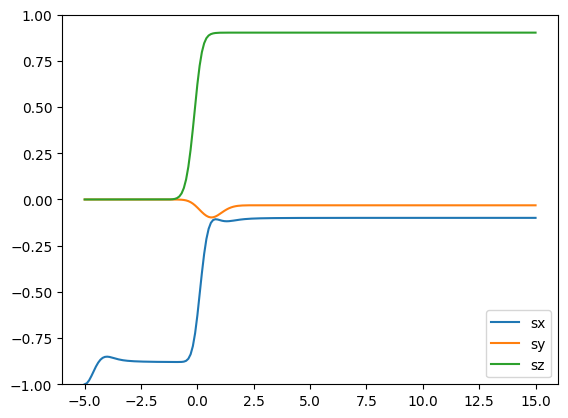

In [3]:
detuning = lambda t: 0.0 * t
def gaussian_shape(t, area = 1.0, tau = 1.0, t_0 = 0.0):
    return area/(tau*np.sqrt(np.pi)) * np.exp(-(t-t_0)**2/(tau**2))

def hamiltonian_t(t):
    return detuning(t)/2.0 * sigma_z \
           + gaussian_shape(t, area = np.pi/2.0, tau = 0.5)/2.0 * sigma_y

system = oqupy.TimeDependentSystem(hamiltonian_t)

Rho_0=oqupy.operators.spin_dm('x-')

dynamics = oqupy.compute_dynamics(
       process_tensor=pt._process_tensor,        
       system=system,
       initial_state=Rho_0,
       start_time=-5.0,
       num_steps=200)

t, s_x = dynamics.expectations(sigma_x, real=True)
_, s_y = dynamics.expectations(sigma_y, real=True)
_, s_z = dynamics.expectations(sigma_z, real=True)

plt.plot(t,s_x,label='sx')
plt.plot(t,s_y,label='sy')
plt.plot(t,s_z,label='sz')
plt.ylim((-1.0,1.0))
plt.legend(loc=4)